In [ ]:
import pandas as pd
import numpy as np
import re
import string
import time
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

In [ ]:
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from pprint import pprint

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pd.set_option('display.max_colwidth',50)
pd.set_option('display.max_row', 100)

# Data Preprocessing

In [ ]:
# read data
url = 'https://raw.githubusercontent.com/Hanyun1126/Twitter-Sentiment-Analysis-for-ChatGPT/main/data/chatgpt-tweets-data-20230310-20230322.csv'
df = pd.read_csv(url)
df

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0
...,...,...,...,...,...,...,...,...
98754,1636521833494351872,2023-03-17 00:16:24+00:00,mlxmo58921,Sorry my phones on da blink n my dyslexic mes...,0,0,1,0
98755,1636521810144673793,2023-03-17 00:16:19+00:00,oshfg66182,If someone were to tell a future version of C...,1,0,2,0
98756,1636521791744032771,2023-03-17 00:16:14+00:00,ecxto33891,ChatGPT can talk to your AWS infrastructure fo...,0,0,0,0
98757,1636521759968219144,2023-03-17 00:16:07+00:00,gukaa66248,"ChatGPT is not yet a human, but some humans ha...",0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98759 entries, 0 to 98758
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            98759 non-null  int64 
 1   Date          98759 non-null  object
 2   Username      98759 non-null  object
 3   Tweet         98759 non-null  object
 4   ReplyCount    98759 non-null  int64 
 5   RetweetCount  98759 non-null  int64 
 6   LikeCount     98759 non-null  int64 
 7   QuoteCount    98759 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.0+ MB


In [ ]:
df = df.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(df))

The total number of data-points after removing the rows with missing values are: 98759


There are no missing valus in the dataset.

## Tokenization

In [ ]:
# Clean the text

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove @mentions
    text = re.sub(r'#\w+', '', text) # remove hashtags
    text = re.sub(r'RT[\s]+', '', text) # remove retweets
    text = re.sub(r'https?:\/\/S+', '', text) # remove hyperlinks
    text = re.sub(r'[^\x00-\x7F]+', '', text) # remove non-ASCII characters
    text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation))) # remove punctutions
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens] # stemming
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens] # lemmatization
    clean_text = ' '.join(lemmatized_tokens)
    return clean_text

df['cleanTweet'] = df['Tweet'].apply(clean_text)
df['cleanTweet'] = df['cleanTweet'].str.lower() # lowercase

In [ ]:
# Define stop words
stop_words = set(stopwords.words('english'))

# Define function to remove stop words
def remove_stopwords(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    filtered_tokens = [token for token in tokens if not token in stop_words]
    # Join the filtered tokens back into a string
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Apply the function to the dataframe column
df['cleanTweet'] = df['cleanTweet'].apply(remove_stopwords)

In [ ]:
#Replace 'chat gpt' with 'chatgpt'
df['cleanTweet'] = df['cleanTweet'].apply(lambda x: re.sub(r'chat gpt', 'chatgpt', x))

In [ ]:
# Tokenize the text in the 'text_column' column
df['Token'] = df['cleanTweet'].apply(lambda x: nltk.word_tokenize(x))

## Built bigram and trigram

In [ ]:
#Build the bigram and trigrams
bigram = Phrases(df['Token'], min_count=100, threshold=100)
# #bigram[df['Token']] will apply the bigram object to each row of the df['Token'] column
df['Bigram'] = bigram[df['Token']]
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = Phrases(df['Bigram'], min_count=100, threshold=100)
df['Trigram'] = trigram[df['Bigram']]
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# Get the bigram and trigram phrases
biphrase = bigram.export_phrases()
triphrase = trigram.export_phrases()
print(f'Bi:{len(biphrase)}, Tri:{len(triphrase)}')

Bi:32, Tri:33


In [ ]:
df[df['Trigram']!=df['Bigram']][0:10]

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,cleanTweet,Token,Bigram,Trigram
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,thread save notion databas tag chatgpt,"[thread, save, notion, databas, tag, chatgpt]","[thread, save_notion, databas_tag, chatgpt]","[thread_save_notion, databas_tag, chatgpt]"
65,1638328600788185088,2023-03-21 23:55:51+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,thread save notion databas tag chatgpt,"[thread, save, notion, databas, tag, chatgpt]","[thread, save_notion, databas_tag, chatgpt]","[thread_save_notion, databas_tag, chatgpt]"
102,1638328022863314947,2023-03-21 23:53:33+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,thread save notion databas tag chatgpt,"[thread, save, notion, databas, tag, chatgpt]","[thread, save_notion, databas_tag, chatgpt]","[thread_save_notion, databas_tag, chatgpt]"
467,1638322684953231360,2023-03-21 23:32:21+00:00,qffze89723,"OpenAI CEO Sam Altman says he, too, is 'a litt...",0,0,0,0,openai ceo sam altman say littl bit scare chat...,"[openai, ceo, sam, altman, say, littl, bit, sc...","[openai, ceo_sam, altman, say, littl, bit, sca...","[openai, ceo_sam_altman, say, littl, bit, scar..."
926,1638315778683420672,2023-03-21 23:04:54+00:00,tztqw10334,OpenAI CEO Sam Altman warns that other A.I. de...,1,0,0,0,openai ceo sam altman warn develop work chatgp...,"[openai, ceo, sam, altman, warn, develop, work...","[openai, ceo_sam, altman, warn, develop, work,...","[openai, ceo_sam_altman, warn, develop, work, ..."
1196,1638312597899362304,2023-03-21 22:52:16+00:00,xzofl12404,'OpenAI CEO Sam Altman said…he’s a “little bit...,2,4,6,3,openai ceo sam altman saidh littl bit scare te...,"[openai, ceo, sam, altman, saidh, littl, bit, ...","[openai, ceo_sam, altman, saidh, littl, bit, s...","[openai, ceo_sam_altman, saidh, littl, bit, sc..."
1553,1638307808729808903,2023-03-21 22:33:14+00:00,yjwuq44187,OpenAI CEO Sam Altman warns that other A.I. de...,1,0,0,0,openai ceo sam altman warn develop work chatgp...,"[openai, ceo, sam, altman, warn, develop, work...","[openai, ceo_sam, altman, warn, develop, work,...","[openai, ceo_sam_altman, warn, develop, work, ..."
2260,1638298437031534600,2023-03-21 21:56:00+00:00,vzegq38752,"OpenAI CEO Sam Altman says he, too, is 'a litt...",1,0,0,0,openai ceo sam altman say littl bit scare chat...,"[openai, ceo, sam, altman, say, littl, bit, sc...","[openai, ceo_sam, altman, say, littl, bit, sca...","[openai, ceo_sam_altman, say, littl, bit, scar..."
2751,1638291821720682500,2023-03-21 21:29:42+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,thread save notion databas tag chatgpt,"[thread, save, notion, databas, tag, chatgpt]","[thread, save_notion, databas_tag, chatgpt]","[thread_save_notion, databas_tag, chatgpt]"
2804,1638291177119289345,2023-03-21 21:27:09+00:00,lklud30456,"OpenAI CEO Sam Altman says he, too, is 'a litt...",1,0,0,0,openai ceo sam altman say littl bit scare chatgpt,"[openai, ceo, sam, altman, say, littl, bit, sc...","[openai, ceo_sam, altman, say, littl, bit, sca...","[openai, ceo_sam_altman, say, littl, bit, scar..."


In [ ]:
# Get the bigram and trigram vocabularies
bigram_vocab = bigram.vocab
trigram_vocab = trigram.vocab

# Sort the bigram and trigram vocabularies by frequency in descending order
sorted_bigram_vocab = sorted(biphrase.items(), key=lambda x: x[1], reverse=True)
sorted_trigram_vocab = sorted(triphrase.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 most common bigrams and trigrams
print("Top 20 most common bigrams:")
for phrase, freq in sorted_bigram_vocab[:20]:
    print("{}: {}".format(phrase, freq))

print("\nTop 20 most common trigrams:")
for phrase, freq in sorted_trigram_vocab[:20]:
    print("{}: {}".format(phrase, freq))

Top 20 most common bigrams:
sam_altman: 858.5527884398284
south_park: 752.7279521001216
notion_databas: 586.3136754783897
databas_tag: 582.7282227200313
rsi_85: 581.3105639691536
gon_na: 553.8943771043771
elon_musk: 518.3756544690374
stabl_diffus: 461.1542407660739
recommend_ticker: 458.8143169760843
social_medium: 359.54408517061864
minut_candl: 325.1991386735573
artifici_intellig: 282.97614911113226
chrome_extens: 261.16443077273635
85_recommend: 258.61120767156126
dall_e: 251.8372142832665
youtub_channel: 245.55502621844641
game_changer: 192.18334870995452
ticker_30: 190.02168636968605
real_estat: 175.96757587640187
ceo_sam: 154.61476905684756

Top 20 most common trigrams:
gon_na: 300896.00913242006
real_estat: 41579.446336047375
stabl_diffus: 27557.80612244898
recommend_ticker: 17342.5056372549
game_changer: 16131.972266666666
rsi_85_recommend_ticker: 16070.072727272727
south_park: 15619.517723880597
rsi_85: 13626.66985645933
artifici_intellig: 9129.212315525525
wan_na: 8821.982613

In [ ]:
# bi-gram and tri-gram implementation
df['Token'] = df['Token'].apply(lambda x:bigram_mod[x])
df['Token']= df['Token'].apply(lambda x:trigram_mod[bigram_mod[x]])

In [ ]:
df.shape

(98759, 12)

# Create the Dictionary and Corpus

1. Dictionary Creation:

In NLP, a dictionary is a collection of unique words or terms that appear in the text data. Each word or term is assigned a unique numerical ID, which is used to represent that word or term throughout the analysis. The creation of a dictionary typically involves scanning the text data to identify all unique words or terms, and then assigning each one a unique ID.

2. Corpus Creation:

In NLP, a corpus is a collection of documents or texts that are analyzed as a group. The creation of a corpus involves transforming the raw text data into a numerical representation that can be used for further analysis. This typically involves converting each document into a bag-of-words representation, where each word in the document is represented by its corresponding ID in the dictionary, and the frequency of each word is counted.

In [ ]:
dictionary = Dictionary(df['Token'])
print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 34976


In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in df['Token']]

#create a dictionary to show the word and frequency in the corpus
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if dictionary[idx] in dict_corpus:
            dict_corpus[dictionary[idx]] += freq
        else: 
            dict_corpus[dictionary[idx]] = freq
df_dict = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['frequency'])

In [ ]:
# Top 10 high-frequency words 
df_dict.sort_values('frequency', ascending = False).head(10)

,frequency
chatgpt,82495
use,16249
ai,15622
like,8927
ask,8557
4,8281
write,6504
wa,6237
get,5971
make,5785


## Filter extreme words

In [ ]:
# Filter extreme words
dictionary.filter_extremes(no_below=10, no_above=0.5)  #words occur in less than 10 tweets, or more than 50% of tweets
print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 4267


In [ ]:
# Recreate the corpus for LDA model
corpus = [dictionary.doc2bow(doc) for doc in df['Token']]

In [ ]:
# Re-check the top words
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if dictionary[idx] in dict_corpus:
            dict_corpus[dictionary[idx]] += freq
        else: 
            dict_corpus[dictionary[idx]] = freq
df_dict_new = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['frequency'])
df_dict_new.sort_values('frequency', ascending = False).head(10)

,frequency
use,16249
ai,15622
like,8927
ask,8557
4,8281
write,6504
wa,6237
get,5971
make,5785
ha,5381


In [ ]:
len(corpus),len(dictionary)

(98759, 4267)

In [ ]:
# Generate a test corpus
corpus_test = [dictionary.doc2bow(doc) for doc in df['Token'][0:1000]]

# LDA model 


## Implementation

In [ ]:
num_topics = 10
passes = 10
total_iteration = num_topics*passes

# train the LdaModel
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

In [ ]:
# Display topics
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('googl', 0.050338157),
   ('ai', 0.04460924),
   ('microsoft', 0.039879728),
   ('via', 0.038903713),
   ('search', 0.033989582),
   ('chatbot', 0.03034633),
   ('bing', 0.02980108),
   ('baidu', 0.020978848),
   ('open', 0.018434642),
   ('openai', 0.01788077)]),
 (1,
  [('ask', 0.033833068),
   ('use', 0.026918804),
   ('wa', 0.01651824),
   ('write', 0.0158916),
   ('like', 0.014156408),
   ('thing', 0.013390262),
   ('get', 0.012851215),
   ('code', 0.012438548),
   ('tri', 0.012199332),
   ('question', 0.012132988)]),
 (2,
  [('ai', 0.026713701),
   ('like', 0.02453312),
   ('human', 0.018081982),
   ('use', 0.017607613),
   ('peopl', 0.01732683),
   ('know', 0.016849222),
   ('think', 0.016180346),
   ('job', 0.014846887),
   ('talk', 0.013405321),
   ('make', 0.011456052)]),
 (3,
  [('ai', 0.04580333),
   ('use', 0.02144028),
   ('generat', 0.021202436),
   ('prompt', 0.015008022),
   ('tool', 0.014164897),
   ('amp', 0.013418148),
   ('languag', 0.012492158),
   ('new'

In [ ]:
#Compute Coherence Score
cm = CoherenceModel(model=lda_model, corpus = corpus, coherence='c_v', texts=df['Token'])
coherence = cm.get_coherence()
print(f'Coherence score: {coherence}')

Coherence score: 0.4600142719246233


## Identification of Topics

In [ ]:
#get the topic distribution for each tweets
topic_dist = [lda_model[doc] for doc in corpus]

In [ ]:
#get the dominant topic and the score
dominant_topic = [max(topic, key=lambda x:x[1])[0] for topic in topic_dist]
scores =[max(topic, key=lambda x:x[1])[1] for topic in topic_dist]

In [ ]:
#Create a dataframe to show dominant topic for each tweet
df_topic = df[['Tweet','Token','Date']].copy()
df_topic['Dominant_Topic'] = [topic+1 for topic in dominant_topic]
df_topic['Contribution%'] = [round(score*100,2) for score in scores]
df_topic

,Tweet,Token,Date,Dominant_Topic,Contribution%
0,ChatGPT is another woke machine.,"[chatgpt, anoth, woke, machin]",2023-03-21 23:59:55+00:00,7,27.50
1,"of the Atlantic, or only near the Atla #推特账号 m...","[atlant, onli, near, atla, green, th]",2023-03-21 23:59:55+00:00,7,30.50
2,This thread is saved to your Notion database....,"[thread_save_notion, databas_tag, chatgpt]",2023-03-21 23:59:50+00:00,8,70.00
3,Prompt AI – ChatGPT #0018,"[prompt, ai, chatgpt]",2023-03-21 23:59:46+00:00,4,70.00
4,Just had some interesting conversations with G...,"[interest, convers, googl, bard, appear, confi...",2023-03-21 23:59:42+00:00,2,50.93
...,...,...,...,...,...
98754,Sorry my phones on da blink n my dyslexic mes...,"[sorri, phone, da, blink, n, dyslex, messag, h...",2023-03-17 00:16:24+00:00,2,37.81
98755,If someone were to tell a future version of C...,"[someon, tell, futur, version, chatgpt, spin, ...",2023-03-17 00:16:19+00:00,6,31.51
98756,ChatGPT can talk to your AWS infrastructure fo...,"[chatgpt, talk, aw, infrastructur, footprint]",2023-03-17 00:16:14+00:00,3,27.50
98757,"ChatGPT is not yet a human, but some humans ha...","[chatgpt, yet, human, human, alreadi, becom, l...",2023-03-17 00:16:07+00:00,3,60.09


In [ ]:
# Count and percentage of tweets for each topic
df_topic_summary = df_topic.groupby('Dominant_Topic').agg({'Tweet':'count'}).copy().reset_index()
df_topic_summary.rename(columns={'Tweet':'Total_tweet'}, inplace=True)
df_topic_summary['Percentage%'] = round(df_topic_summary['Total_tweet']/df_topic.shape[0]*100,2)
df_topic_summary=df_topic_summary.sort_values('Total_tweet', ascending=False).reset_index(drop=True)
df_topic_summary

,Dominant_Topic,Total_tweet,Percentage%
0,2,28558,28.92
1,4,18182,18.41
2,3,15997,16.20
3,1,6984,7.07
4,6,6643,6.73
5,5,6354,6.43
6,10,5427,5.50
7,9,4949,5.01
8,8,3610,3.66
9,7,2055,2.08


In [ ]:
#To sort the highly relevant tweets for each topics and interprete the topic names.
df_topic[df_topic['Dominant_Topic']==1].sort_values('Contribution%', ascending=False)[0:100]

,Tweet,Token,Date,Dominant_Topic,Contribution%
12514,Bard: Google's rival to ChatGPT launches for o...,"[bard, googl, rival, chatgpt, launch, 18, tech...",2023-03-21 14:54:19+00:00,1,95.00
13178,Bard: Google's rival to ChatGPT launches for o...,"[bard, googl, rival, chatgpt, launch, 18, tech...",2023-03-21 14:26:15+00:00,1,95.00
9357,Bard: Google's rival to ChatGPT launches for o...,"[bard, googl, rival, chatgpt, launch, 18, tech...",2023-03-21 16:53:03+00:00,1,95.00
12257,Bard: Google's rival to ChatGPT launches for o...,"[bard, googl, rival, chatgpt, launch, 18, tech...",2023-03-21 15:03:10+00:00,1,95.00
12143,Google opens early access to its ChatGPT rival...,"[googl, open, earli, access, chatgpt, rival, b...",2023-03-21 15:06:44+00:00,1,94.37
...,...,...,...,...,...
8578,Google Launches BARD AI Chatbot To Compete Wit...,"[googl, launch, bard, ai, chatbot, compet, cha...",2023-03-21 17:21:04+00:00,1,88.75
9384,BBC News - Bard: Google's rival to ChatGPT lau...,"[bbc, news, bard, googl, rival, chatgpt, launc...",2023-03-21 16:51:58+00:00,1,88.75
9583,Google launches Bard chatbot to rival OpenAI’s...,"[googl, launch, bard, chatbot, rival, openai, ...",2023-03-21 16:44:14+00:00,1,88.75
9607,Google Launches BARD AI Chatbot To Compete Wit...,"[googl, launch, bard, ai, chatbot, compet, cha...",2023-03-21 16:43:06+00:00,1,88.75


In [ ]:
#Summarize the topic names based on each topics' top terms and highly-relevant tweets 
names = {1:"T1 The possibility of replacing google, bing and other companies after the emergence of AI",
        2:"T2 How to write and use code effectively with AI",
        3:"T3 The impact of AI on the job market",
        4:"T4 Practical applications of AI in natural language processing and text generation",
        5:"T5 The different versions of GPT and their capabilities",
        6:"T6 Creating content or media such as videos, stories, and posts using AI",
        7:"T7 Mind-blowing predictions or calculations made by GPT4",
        8:"T8 Education, personal development, and investing using AI",
        9:"T9 How to build casual or informal online communication using AI",
        10:"T10 Difficult to infer a topic"
        }

In [ ]:
df_topic['Topic_Name'] = df_topic['Dominant_Topic'].map(names)
df_topic.to_csv('Twitter_topics.csv', index=False)

In [ ]:
#creat a topic dataframe
topics = [[(term, round(weight,3)) for term, weight in lda_model.show_topic(n,topn=20)] for n in range(0,lda_model.num_topics)]

In [ ]:
pd.set_option('display.max_colwidth', None)
topic_df = pd.DataFrame({'Topic_Name':names.values(), 
                         'Topic_Terms':[','.join([term for term, weight in topic]) for topic in topics]},
                        index = ['Topic ' + str(n) for n in range(1,lda_model.num_topics+1)])
# apply style to align content to the left
topic_df

,Topic_Name,Topic_Terms
Topic 1,"T1 The possibility of replacing google, bing and other companies after the emergence of AI","googl,ai,microsoft,via,search,chatbot,bing,baidu,open,openai,china,v,chat,tech,news,answer,access,impress,erni_bot,launch"
Topic 2,T2 How to write and use code effectively with AI,"ask,use,wa,write,like,thing,get,code,tri,question,one,answer,make,would,know,time,good,give,help,think"
Topic 3,T3 The impact of AI on the job market,"ai,like,human,use,peopl,know,think,job,talk,make,say,go,replac,ha,work,need,doe,could,even,would"
Topic 4,T4 Practical applications of AI in natural language processing and text generation,"ai,use,generat,prompt,tool,amp,languag,new,learn,creat,product,help,model,content,technolog,power,busi,like,develop,futur"
Topic 5,T5 The different versions of GPT and their capabilities,"4,gpt,3,5,1,2,version,openai,power,releas,api,custom,model,use,0,access,launch,announc,6,app"
Topic 6,"T6 Creating content or media such as videos, stories, and posts using AI","make,use,day,video,creat,wa,stori,watch,post,money,write,wrote,way,new,march,youtub,market,life,friend,free"
Topic 7,T7 Mind-blowing predictions or calculations made by GPT4,"gpt4,siri,mind,predict,surpris,number,crazi,calcul,blow,stay,dm,truth,ahead,live,woman,ban,woke,math,boost,futur"
Topic 8,"Education, personal development, and investing using AI","thank,student,u,love,invest,bring,come,teach,challeng,brain,digit,move,worri,robot,lie,advanc,teacher,care,song,pretti"
Topic 9,How to build casual or informal online communication using AI,"tweet,write,chat,gt,lol,let,twitter,ask,get,report,add,appl,chine,hey,pas,wa,state,written,script,bad"
Topic 10,Difficult to infer a topic,"year,take,month,next,100,week,day,last,20,seo,10,wa,hour,account,plus,pay,el,trade,job,crypto"


In [ ]:
df_temp = df_topic_summary.sort_values('Dominant_Topic')
topic_df['Tweet_count'] = df_temp['Total_tweet'].values
topic_df

,Topic_Name,Topic_Terms,Tweet_count
Topic 1,"T1 The possibility of replacing google, bing and other companies after the emergence of AI","googl,ai,microsoft,via,search,chatbot,bing,baidu,open,openai,china,v,chat,tech,news,answer,access,impress,erni_bot,launch",6984
Topic 2,T2 How to write and use code effectively with AI,"ask,use,wa,write,like,thing,get,code,tri,question,one,answer,make,would,know,time,good,give,help,think",28558
Topic 3,T3 The impact of AI on the job market,"ai,like,human,use,peopl,know,think,job,talk,make,say,go,replac,ha,work,need,doe,could,even,would",15997
Topic 4,T4 Practical applications of AI in natural language processing and text generation,"ai,use,generat,prompt,tool,amp,languag,new,learn,creat,product,help,model,content,technolog,power,busi,like,develop,futur",18182
Topic 5,T5 The different versions of GPT and their capabilities,"4,gpt,3,5,1,2,version,openai,power,releas,api,custom,model,use,0,access,launch,announc,6,app",6354
Topic 6,"T6 Creating content or media such as videos, stories, and posts using AI","make,use,day,video,creat,wa,stori,watch,post,money,write,wrote,way,new,march,youtub,market,life,friend,free",6643
Topic 7,T7 Mind-blowing predictions or calculations made by GPT4,"gpt4,siri,mind,predict,surpris,number,crazi,calcul,blow,stay,dm,truth,ahead,live,woman,ban,woke,math,boost,futur",2055
Topic 8,"Education, personal development, and investing using AI","thank,student,u,love,invest,bring,come,teach,challeng,brain,digit,move,worri,robot,lie,advanc,teacher,care,song,pretti",3610
Topic 9,How to build casual or informal online communication using AI,"tweet,write,chat,gt,lol,let,twitter,ask,get,report,add,appl,chine,hey,pas,wa,state,written,script,bad",4949
Topic 10,Difficult to infer a topic,"year,take,month,next,100,week,day,last,20,seo,10,wa,hour,account,plus,pay,el,trade,job,crypto",5427


## Visulaization

### Bar chart

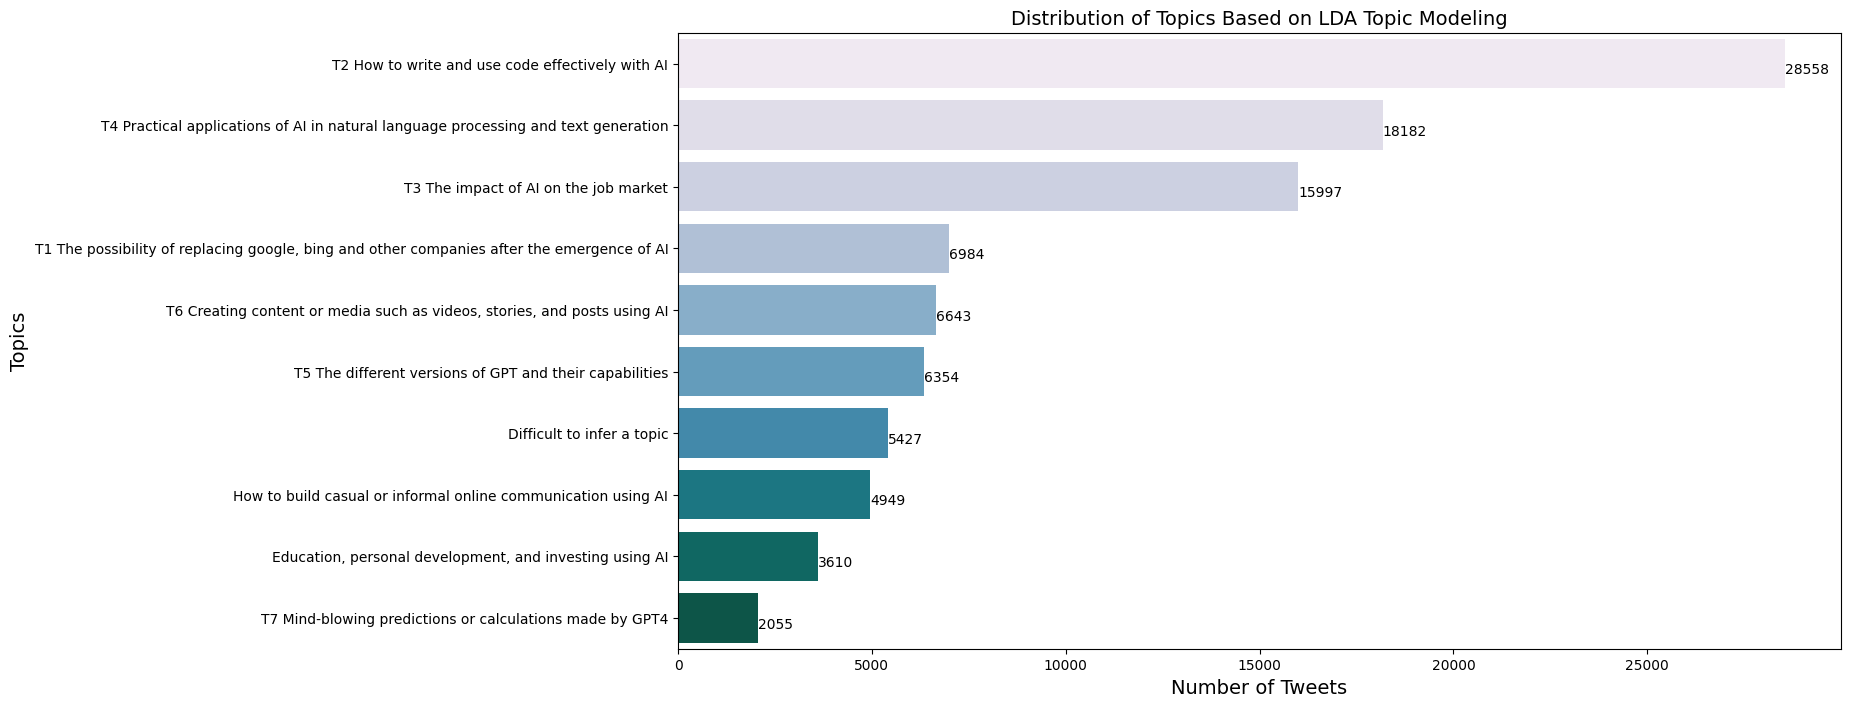

In [ ]:
#plot a bar chart to show the number of tweets for each topic
sort_name = topic_df.sort_values('Tweet_count',ascending=False)['Topic_Name'].to_list()
fig,ax = plt.subplots(1,1,figsize=(15,8))
ax = sns.barplot(y=topic_df['Topic_Name'], x=topic_df['Tweet_count'], order=sort_name, palette='PuBuGn')
for i in ax.patches:
    ax.annotate(int(i.get_width()), (i.get_width(), i.get_y()+0.5), va='center')
ax.set_ylabel('Topics', size=14)
ax.set_xlabel('Number of Tweets', size=14)
ax.set_title('Distribution of Topics Based on LDA Topic Modeling', size=14)

plt.show()

### Word Cloud

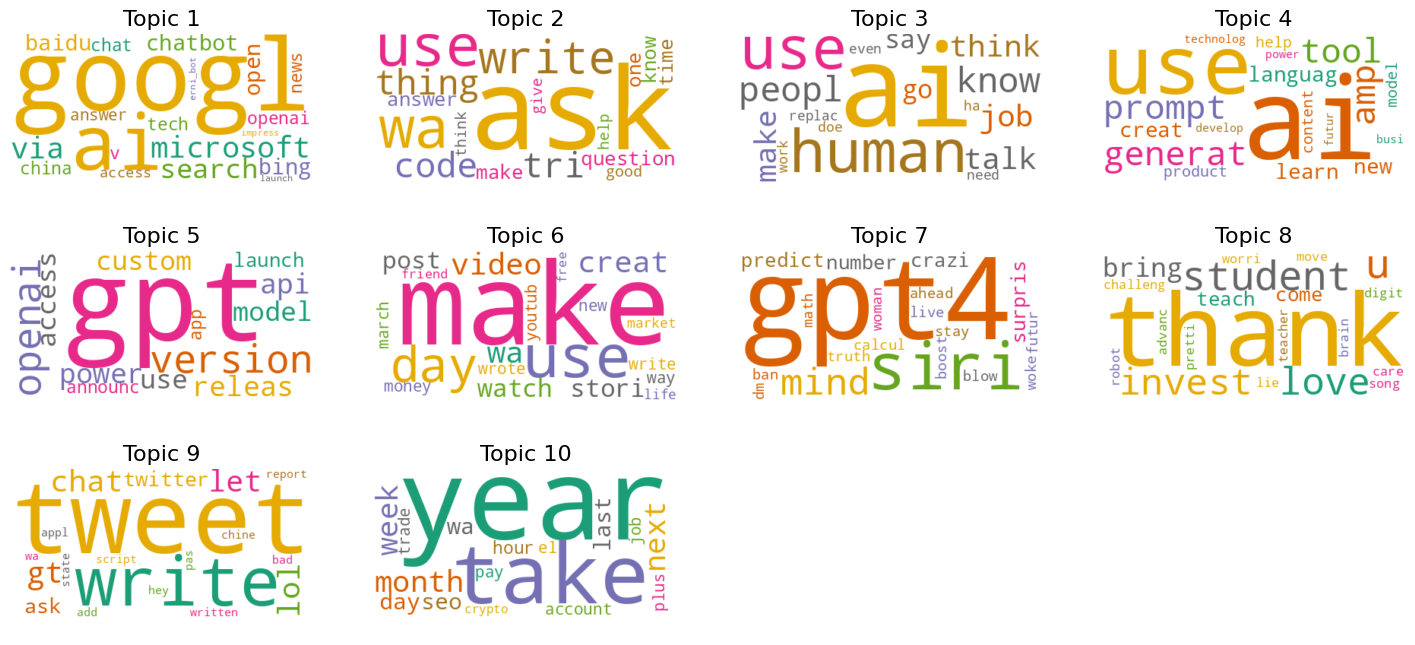

In [ ]:
# word cloud
from wordcloud import WordCloud
wc = WordCloud(background_color='white', colormap='Dark2', max_font_size=150, random_state=42)
fig, axs = plt.subplots(3,4, figsize=(18,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    if i<10:
        wc.generate(topic_df['Topic_Terms'][i])
        plt.subplot(3,4,i+1)
        plt.imshow(wc, interpolation="bilinear")
        plt.title(topic_df.index[i], size=16)
    plt.axis('off')

plt.show()